

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Get Data


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp   
from PIL import Image

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

Initial Parameters

In [52]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*10/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':15},
        'lenet':{'dropout':0.1, 'epochs':15},
        'custom':{'dropout':0.1, 'epochs':15},
        'vgg':{'dropout':0.3, 'epochs':15},
        'resnet':{'epochs':15},
        'pretrained':{'epochs':5}   
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-08-15 12:43:23,288: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json


In [61]:
getattr(params.fine_tune_callbacks, 'ModelCheckpoint1', None) is not None 

False

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*10<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

In [8]:
Counter(train_labels)

Counter({6: 5000,
         9: 5000,
         4: 5000,
         1: 5000,
         2: 5000,
         7: 5000,
         8: 5000,
         3: 5000,
         5: 5000,
         0: 5000})

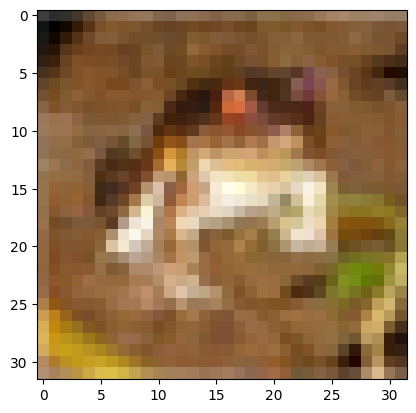

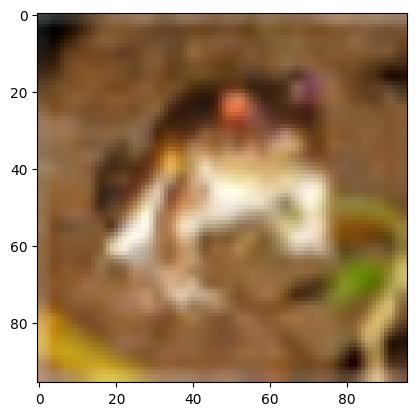

(32, 32, 3) (96, 96, 3)


In [9]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(96, 96) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [10]:
train_images = resize_images(train_images, input_shape)
test_images = resize_images(test_images, input_shape)

In [11]:
print(train_images.shape, type(train_images), train_images.dtype)
print(test_images.shape, type(test_images), test_images.dtype) 

(50000, 96, 96, 3) <class 'numpy.ndarray'> uint8
(10000, 96, 96, 3) <class 'numpy.ndarray'> uint8




### Data Explore 

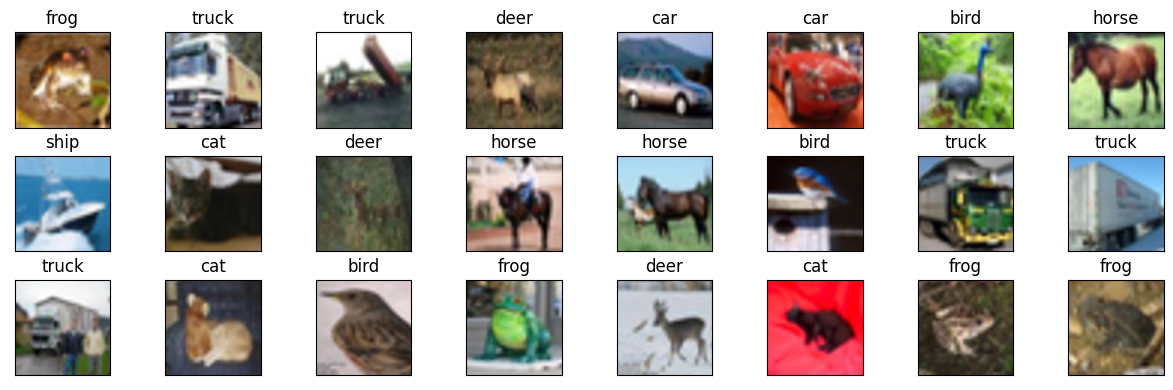

In [12]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Class Distribution

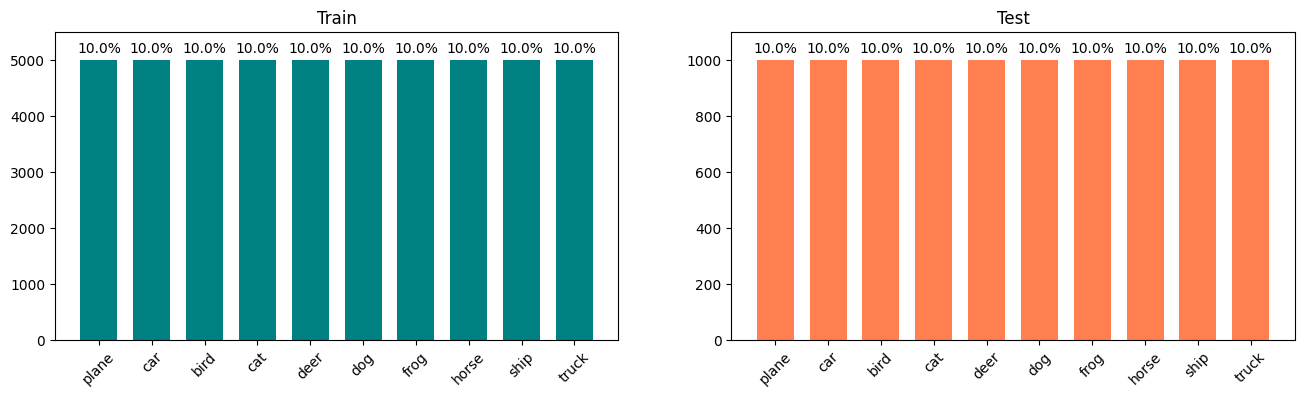

In [13]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [14]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [15]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [16]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 96, 96, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

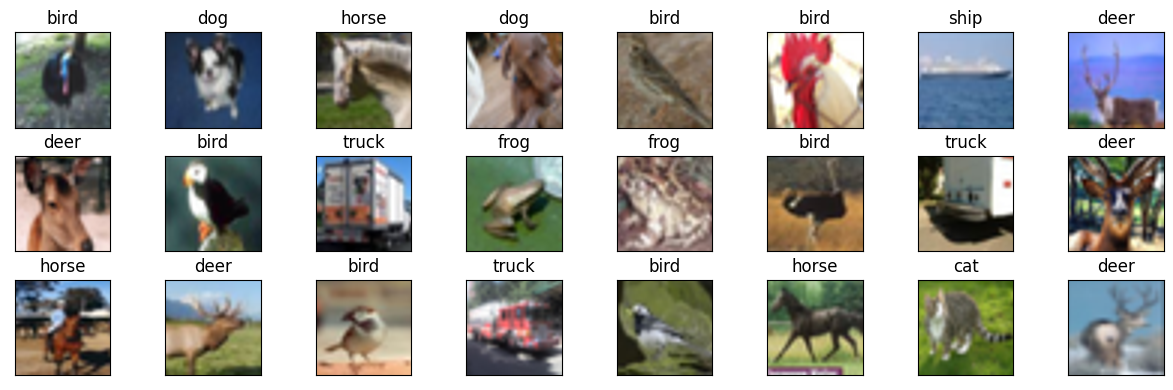

In [17]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [18]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

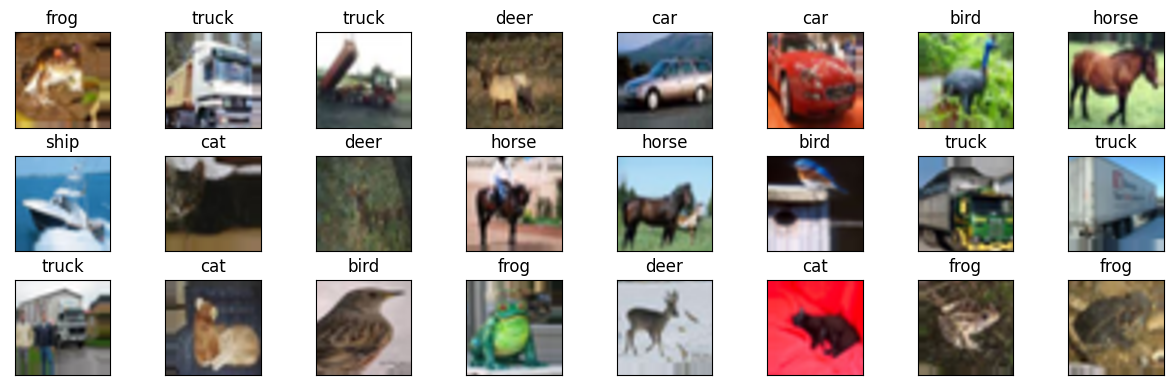

In [19]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

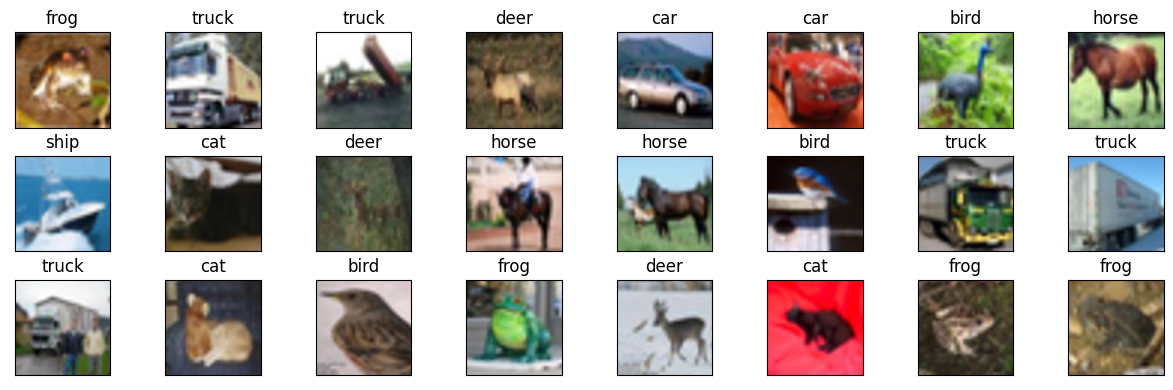

In [20]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [21]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [22]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


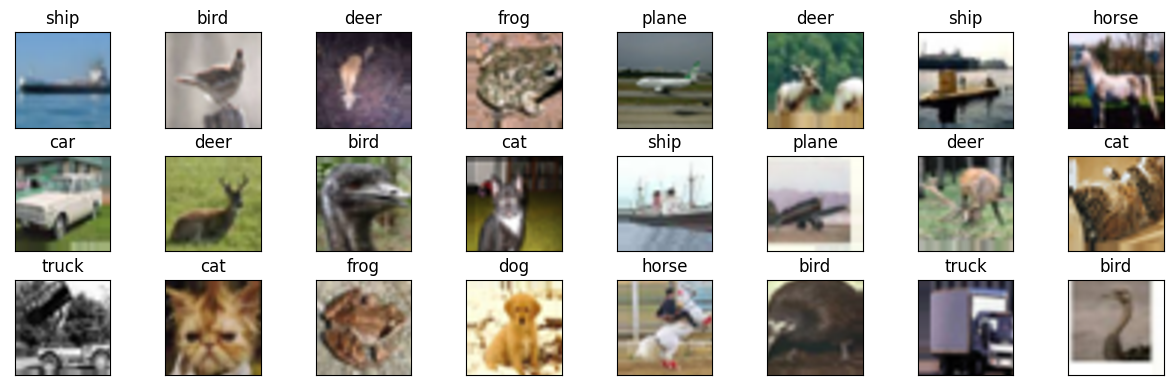

In [23]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [27]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### MLP

2022-08-12 15:15:11,670: INFO: model_params.mlp1.dropout=0.1
2022-08-12 15:15:11,671: INFO: model_params.mlp1.layer_count=1
2022-08-12 15:15:11,672: INFO: model_params.mlp1.units=128
2022-08-12 15:15:11,727: INFO: learning_rate=0.001
2022-08-12 15:15:11,727: INFO: model_params.mlp1.clip_value=None
2022-08-12 15:15:11,733: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 27648)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3539072   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,540,362
Trainable params: 3,540,362
Non-traina

2022-08-12 15:15:11,749: INFO: model_params.mlp1.epochs=15
2022-08-12 15:15:11,750: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1, monitor=val_accuracy)
2022-08-12 15:15:11,751: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-12 15:15:11,751: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-12 15:15:11,752: INFO: use LearningRateScheduler()
2022-08-12 15:15:11,753: INFO: steps_per_epoch=1562
2022-08-12 15:15:11,753: INFO: start training
2022-08-12 15:15:11,754: INFO: use_class_weight=False


Epoch 1/15
1546/1562 [============================>.] - ETA: 0s - loss: 4.1086 - accuracy: 0.3118INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


2022-08-12 15:15:17,910: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


1562/1562 [==============================] - 6s 4ms/step - loss: 4.0849 - accuracy: 0.3128 - val_loss: 1.8878 - val_accuracy: 0.4011 - lr: 0.0010
Epoch 2/15
1562/1562 [==============================] - ETA: 0s - loss: 1.7265 - accuracy: 0.4149INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


2022-08-12 15:15:23,344: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7265 - accuracy: 0.4149 - val_loss: 1.6619 - val_accuracy: 0.4295 - lr: 0.0010
Epoch 3/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6822 - accuracy: 0.4282 - val_loss: 1.7520 - val_accuracy: 0.4136 - lr: 0.0010
Epoch 4/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.7134 - accuracy: 0.4279 - val_loss: 1.8005 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 5/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.7245 - accuracy: 0.4334 - val_loss: 1.8329 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 6/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.7089 - accuracy: 0.4403 - val_loss: 1.9269 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 7/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.7041 - accuracy: 0.4473 - val_loss: 1.9782 - val_accuracy: 0.4103 - lr: 0.0010
Epoch 8/15
1555/1562 [============================>.] - ETA: 0s - los

2022-08-12 15:15:52,697: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


1562/1562 [==============================] - 6s 4ms/step - loss: 1.6792 - accuracy: 0.4547 - val_loss: 1.8001 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 9/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6704 - accuracy: 0.4597 - val_loss: 1.9304 - val_accuracy: 0.4153 - lr: 0.0010
Epoch 10/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6546 - accuracy: 0.4685 - val_loss: 1.8613 - val_accuracy: 0.4230 - lr: 0.0010
Epoch 11/15
1544/1562 [============================>.] - ETA: 0s - loss: 1.6362 - accuracy: 0.4723INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


2022-08-12 15:16:07,577: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6345 - accuracy: 0.4725 - val_loss: 1.8484 - val_accuracy: 0.4355 - lr: 0.0010
Epoch 12/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6327 - accuracy: 0.4775 - val_loss: 1.9497 - val_accuracy: 0.4193 - lr: 0.0010
Epoch 13/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6086 - accuracy: 0.4852 - val_loss: 1.9542 - val_accuracy: 0.4199 - lr: 0.0010
Epoch 14/15
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6081 - accuracy: 0.4877 - val_loss: 1.9271 - val_accuracy: 0.4213 - lr: 0.0010
Epoch 15/15
1552/1562 [============================>.] - ETA: 0s - loss: 1.5914 - accuracy: 0.4923INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


2022-08-12 15:16:27,225: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.5906 - accuracy: 0.4925 - val_loss: 1.8729 - val_accuracy: 0.4367 - lr: 0.0010


2022-08-12 15:16:27,252: INFO: finish training [elapsed time: 75.50 seconds]


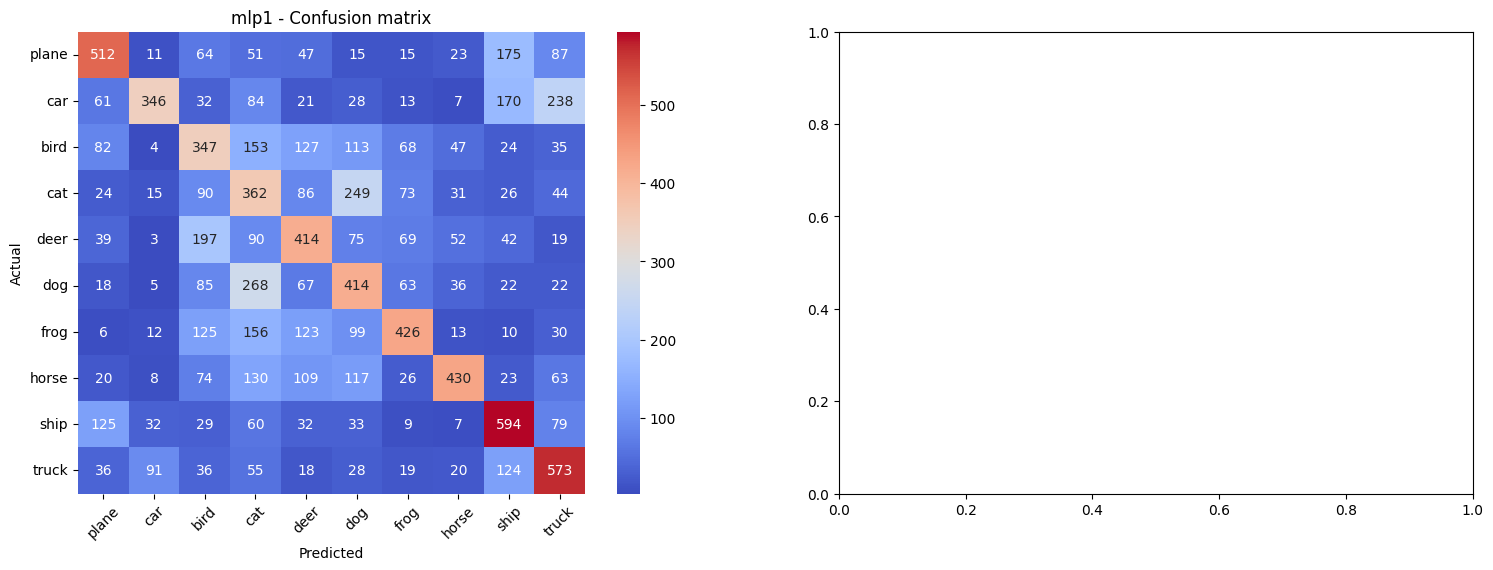

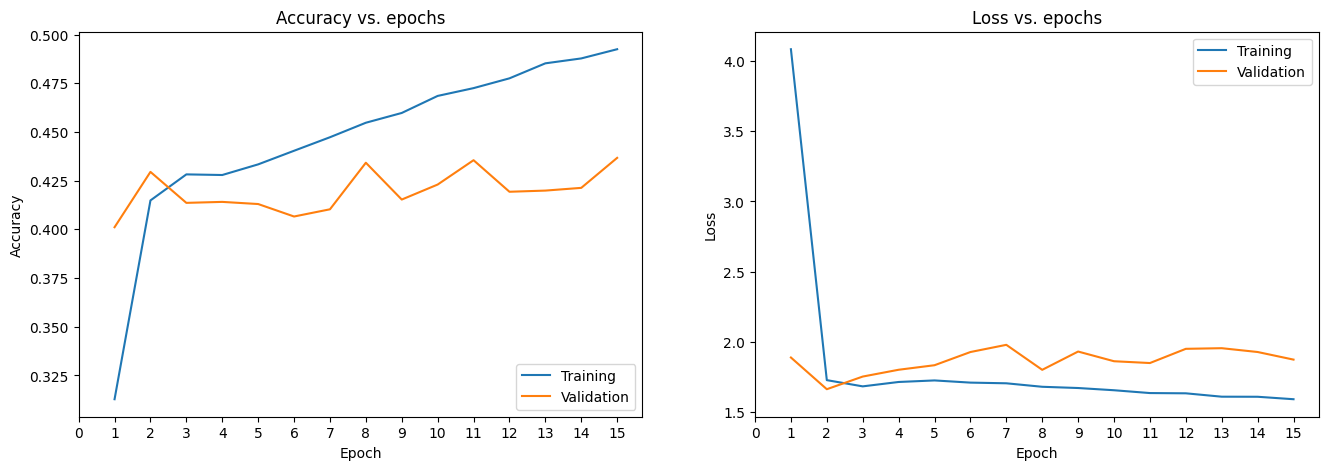

2022-08-12 15:16:28,211: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-12 15:16:43,068: INFO: test loss:1.8729
2022-08-12 15:16:43,069: INFO: test accuracy:0.4367
2022-08-12 15:16:43,070: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-12 15:16:43,072: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-12 15:16:43,073: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:16:43,074: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 1s 2ms/step


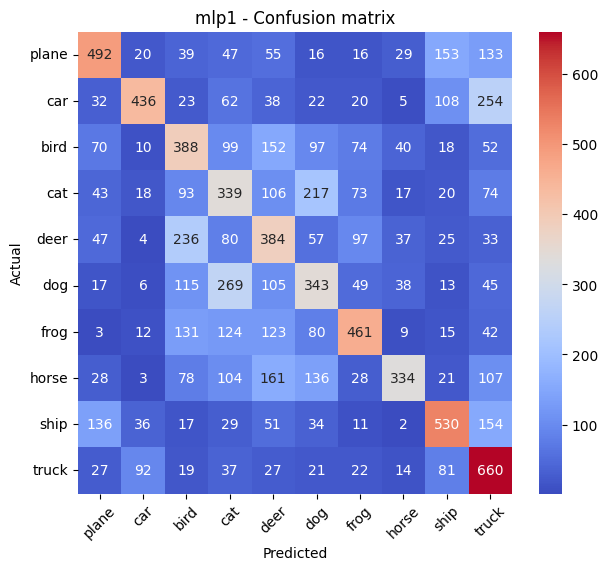

----------------------------------------sample analysis----------------------------------------
1/1 [==============================] - 0s 8ms/step


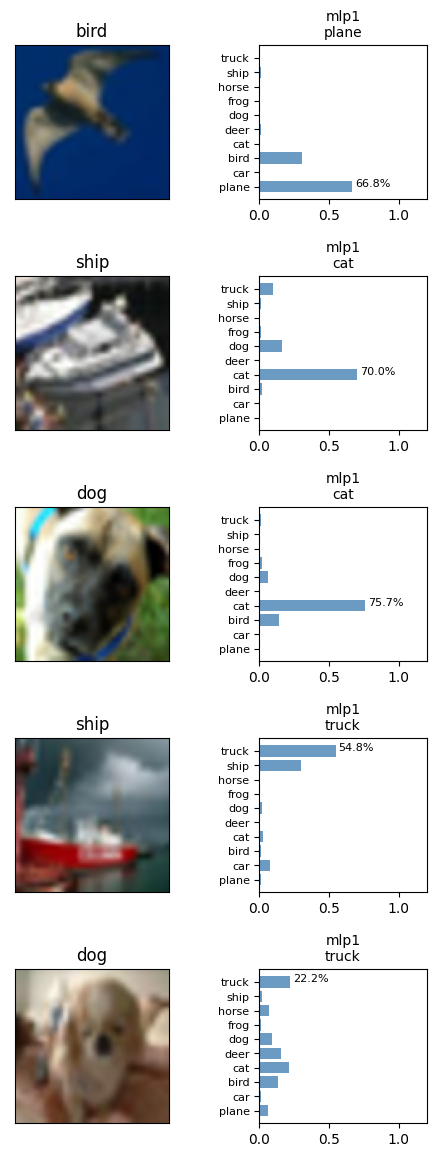

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       mlp1  cifar10_0808_cnt_5000.ipynb        3540362        75.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-12 15:16      1.5546     1.8729          0.4962         0.4367   

   train_auc  test_auc  
1      0.881    0.8425

In [28]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-12 15:16:47,342: INFO: model_params.lenet1.dropout=0.1
2022-08-12 15:16:47,430: INFO: learning_rate=0.001
2022-08-12 15:16:47,431: INFO: model_params.lenet1.clip_value=None
2022-08-12 15:16:47,437: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 6)        0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 6)         0    

2022-08-12 15:16:47,470: INFO: model_params.lenet1.epochs=15
2022-08-12 15:16:47,470: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1, monitor=val_accuracy)
2022-08-12 15:16:47,471: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-12 15:16:47,471: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-12 15:16:47,472: INFO: use LearningRateScheduler()
2022-08-12 15:16:47,473: INFO: steps_per_epoch=1562
2022-08-12 15:16:47,473: INFO: start training
2022-08-12 15:16:47,474: INFO: use_class_weight=False


Epoch 1/15
1562/1562 [==============================] - ETA: 0s - loss: 1.6357 - accuracy: 0.4177

2022-08-12 15:16:59,916: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


2022-08-12 15:17:00,486: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


1562/1562 [==============================] - 13s 7ms/step - loss: 1.6357 - accuracy: 0.4177 - val_loss: 1.3320 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 2/15
1554/1562 [============================>.] - ETA: 0s - loss: 1.2531 - accuracy: 0.5550

2022-08-12 15:17:11,500: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


2022-08-12 15:17:12,073: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


1562/1562 [==============================] - 12s 7ms/step - loss: 1.2523 - accuracy: 0.5552 - val_loss: 1.1549 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 3/15
1561/1562 [============================>.] - ETA: 0s - loss: 1.0578 - accuracy: 0.6277

2022-08-12 15:17:22,835: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


2022-08-12 15:17:23,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 1.0581 - accuracy: 0.6275 - val_loss: 1.0679 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 4/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.9158 - accuracy: 0.6775

2022-08-12 15:17:34,164: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


2022-08-12 15:17:34,723: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.9160 - accuracy: 0.6774 - val_loss: 1.0529 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 5/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.8031 - accuracy: 0.7176 - val_loss: 1.0911 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 6/15
1562/1562 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7520

2022-08-12 15:17:55,062: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


2022-08-12 15:17:55,909: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1/assets


1562/1562 [==============================] - 12s 7ms/step - loss: 0.7062 - accuracy: 0.7520 - val_loss: 1.1222 - val_accuracy: 0.6426 - lr: 0.0010
Epoch 7/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.6300 - accuracy: 0.7797 - val_loss: 1.2106 - val_accuracy: 0.6367 - lr: 0.0010
Epoch 8/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.5573 - accuracy: 0.8062 - val_loss: 1.2623 - val_accuracy: 0.6385 - lr: 0.0010
Epoch 9/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.4982 - accuracy: 0.8254 - val_loss: 1.3222 - val_accuracy: 0.6382 - lr: 0.0010
Epoch 10/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.4484 - accuracy: 0.8451 - val_loss: 1.3877 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 11/15
1562/1562 [==============================] - 10s 6ms/step - loss: 0.4075 - accuracy: 0.8598 - val_loss: 1.4814 - val_accuracy: 0.6345 - lr: 0.0010
Epoch 12/15
1562/1562 [==============================] - 10s 

2022-08-12 15:19:22,394: INFO: finish training [elapsed time: 154.92 seconds]


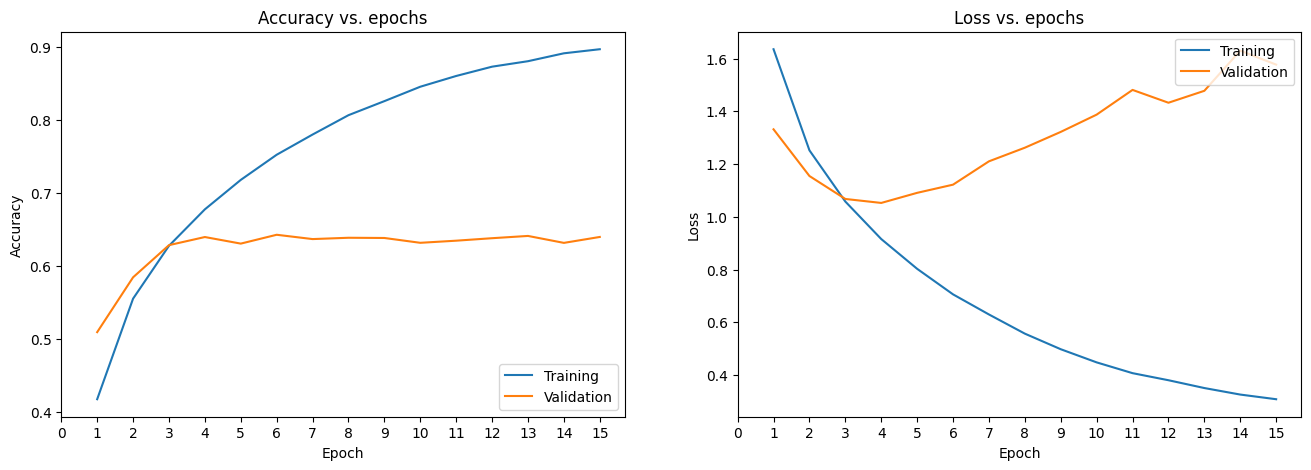

2022-08-12 15:19:22,776: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-12 15:19:41,926: INFO: test loss:1.1222
2022-08-12 15:19:41,927: INFO: test accuracy:0.6426
2022-08-12 15:19:41,928: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-12 15:19:41,930: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-12 15:19:41,931: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:19:41,932: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:19:41,932: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-12 15:19:42,278: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


313/313 [==============================] - 1s 2ms/step


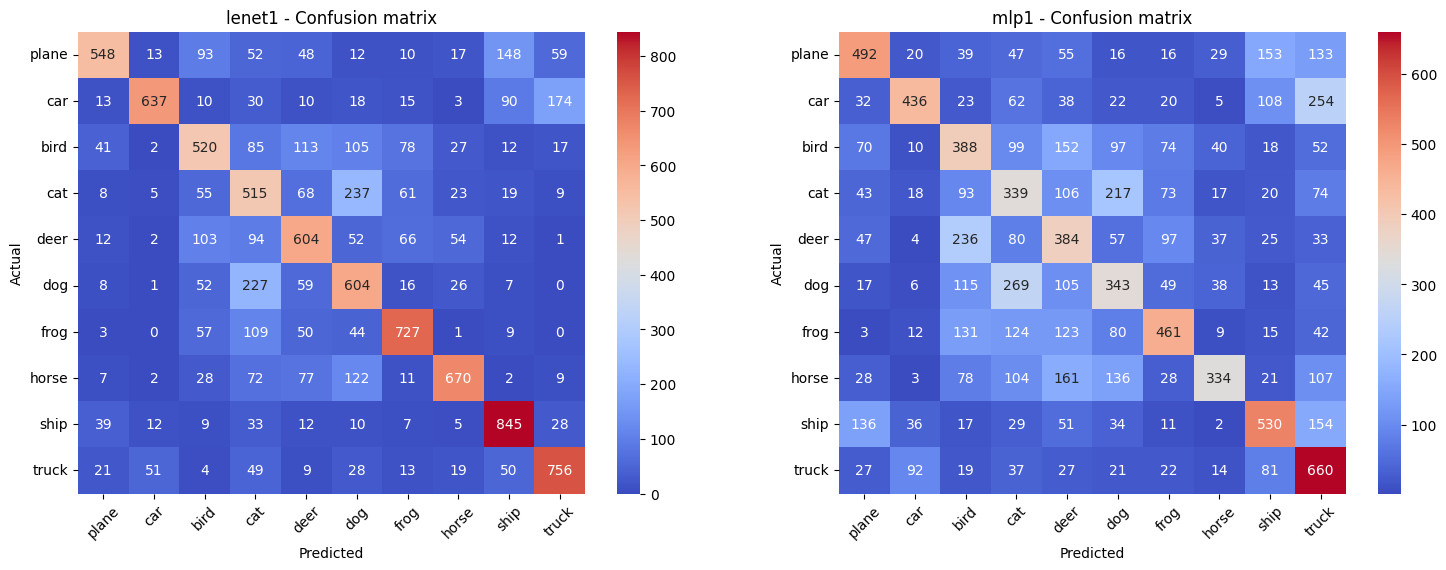

2022-08-12 15:19:46,375: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1


----------------------------------------sample analysis----------------------------------------


2022-08-12 15:19:46,701: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


1/1 [==============================] - 0s 8ms/step


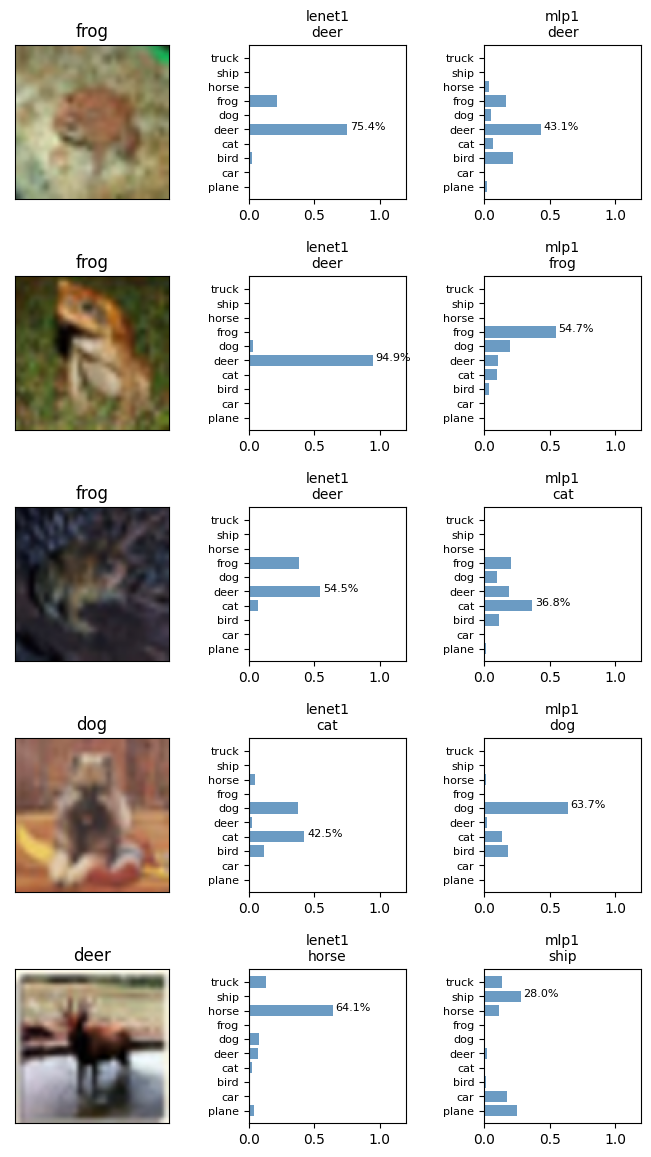

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  cifar10_0808_cnt_5000.ipynb         943330       154.9   
2       mlp1  cifar10_0808_cnt_5000.ipynb        3540362        75.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-12 15:19      0.5487     1.1222          0.8090         0.6426   
2  2022-08-12 15:16      1.5546     1.8729          0.4962         0.4367   

   train_auc  test_auc  
1      0.983    0.9370  
2      0.881    0.8425

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Custom 1


2022-08-12 15:19:50,041: INFO: model_params.custom1.dropout=0.1
2022-08-12 15:19:50,140: INFO: learning_rate=0.001
2022-08-12 15:19:50,141: INFO: model_params.custom1.clip_value=None
2022-08-12 15:19:50,147: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 32)        0   

2022-08-12 15:19:50,181: INFO: model_params.custom1.epochs=15
2022-08-12 15:19:50,181: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1, monitor=val_accuracy)
2022-08-12 15:19:50,182: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-12 15:19:50,182: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-12 15:19:50,183: INFO: use LearningRateScheduler()
2022-08-12 15:19:50,184: INFO: steps_per_epoch=1562
2022-08-12 15:19:50,184: INFO: start training
2022-08-12 15:19:50,185: INFO: use_class_weight=False


Epoch 1/15
1562/1562 [==============================] - ETA: 0s - loss: 1.5439 - accuracy: 0.4397

2022-08-12 15:20:13,199: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:20:13,835: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 24s 15ms/step - loss: 1.5439 - accuracy: 0.4397 - val_loss: 1.1713 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 2/15
1559/1562 [============================>.] - ETA: 0s - loss: 1.1309 - accuracy: 0.5949

2022-08-12 15:20:35,502: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:20:36,144: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.1308 - accuracy: 0.5950 - val_loss: 1.0161 - val_accuracy: 0.6449 - lr: 0.0010
Epoch 3/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.9911 - accuracy: 0.6504

2022-08-12 15:20:57,690: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:20:58,321: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.9915 - accuracy: 0.6504 - val_loss: 0.9813 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 4/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.8874 - accuracy: 0.6893

2022-08-12 15:21:20,185: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:21:20,829: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 23s 14ms/step - loss: 0.8876 - accuracy: 0.6892 - val_loss: 0.9149 - val_accuracy: 0.6871 - lr: 0.0010
Epoch 5/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.8028 - accuracy: 0.7183

2022-08-12 15:21:42,387: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:21:43,032: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.8032 - accuracy: 0.7182 - val_loss: 0.8941 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 6/15
1562/1562 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.7474

2022-08-12 15:22:04,620: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:22:05,260: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.7290 - accuracy: 0.7474 - val_loss: 0.8809 - val_accuracy: 0.7068 - lr: 0.0010
Epoch 7/15
1559/1562 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.7685

2022-08-12 15:22:27,158: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:22:27,821: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 23s 14ms/step - loss: 0.6629 - accuracy: 0.7684 - val_loss: 0.9038 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 8/15
1562/1562 [==============================] - 20s 13ms/step - loss: 0.5969 - accuracy: 0.7898 - val_loss: 0.9179 - val_accuracy: 0.7131 - lr: 0.0010
Epoch 9/15
1558/1562 [============================>.] - ETA: 0s - loss: 0.5475 - accuracy: 0.8075

2022-08-12 15:23:09,651: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:23:10,296: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.5476 - accuracy: 0.8075 - val_loss: 0.9350 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 10/15
1562/1562 [==============================] - 20s 13ms/step - loss: 0.5018 - accuracy: 0.8220 - val_loss: 1.0058 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 11/15
1562/1562 [==============================] - 20s 13ms/step - loss: 0.4664 - accuracy: 0.8355 - val_loss: 1.0369 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 12/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.8479

2022-08-12 15:24:12,292: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:24:12,939: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.4353 - accuracy: 0.8478 - val_loss: 1.0385 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 13/15
1562/1562 [==============================] - 20s 13ms/step - loss: 0.4125 - accuracy: 0.8547 - val_loss: 1.0103 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 14/15
1562/1562 [==============================] - 20s 13ms/step - loss: 0.3859 - accuracy: 0.8607 - val_loss: 1.0668 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 15/15
1560/1562 [============================>.] - ETA: 0s - loss: 0.3679 - accuracy: 0.8694

2022-08-12 15:25:14,973: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


2022-08-12 15:25:15,627: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.3681 - accuracy: 0.8693 - val_loss: 1.0402 - val_accuracy: 0.7273 - lr: 0.0010


2022-08-12 15:25:15,691: INFO: finish training [elapsed time: 325.51 seconds]


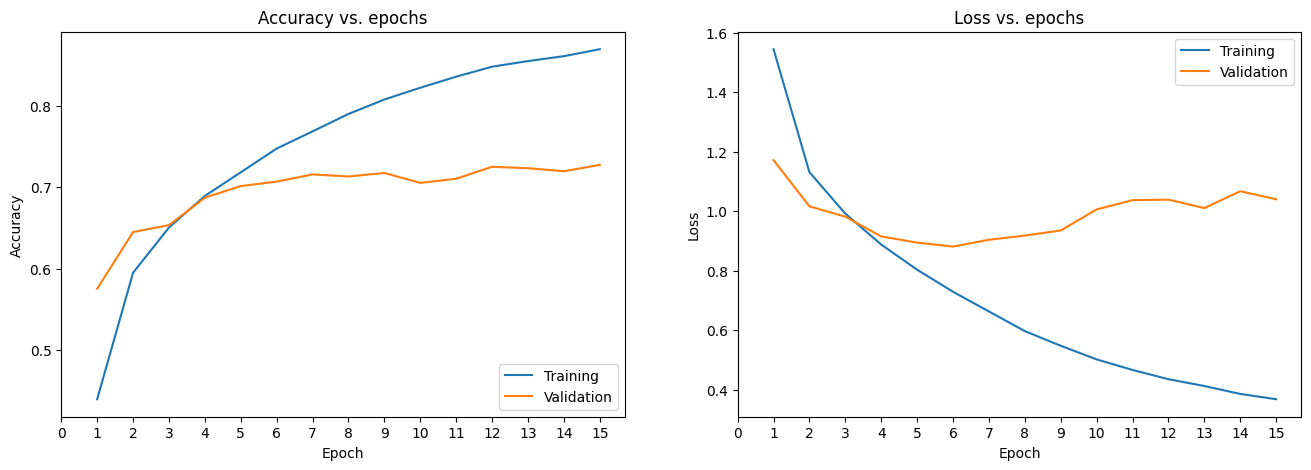

2022-08-12 15:25:16,411: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-12 15:25:38,988: INFO: test loss:1.0402
2022-08-12 15:25:38,988: INFO: test accuracy:0.7273
2022-08-12 15:25:38,990: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-12 15:25:38,992: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-12 15:25:38,992: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:25:38,993: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:25:38,994: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-12 15:25:39,801: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


313/313 [==============================] - 1s 3ms/step


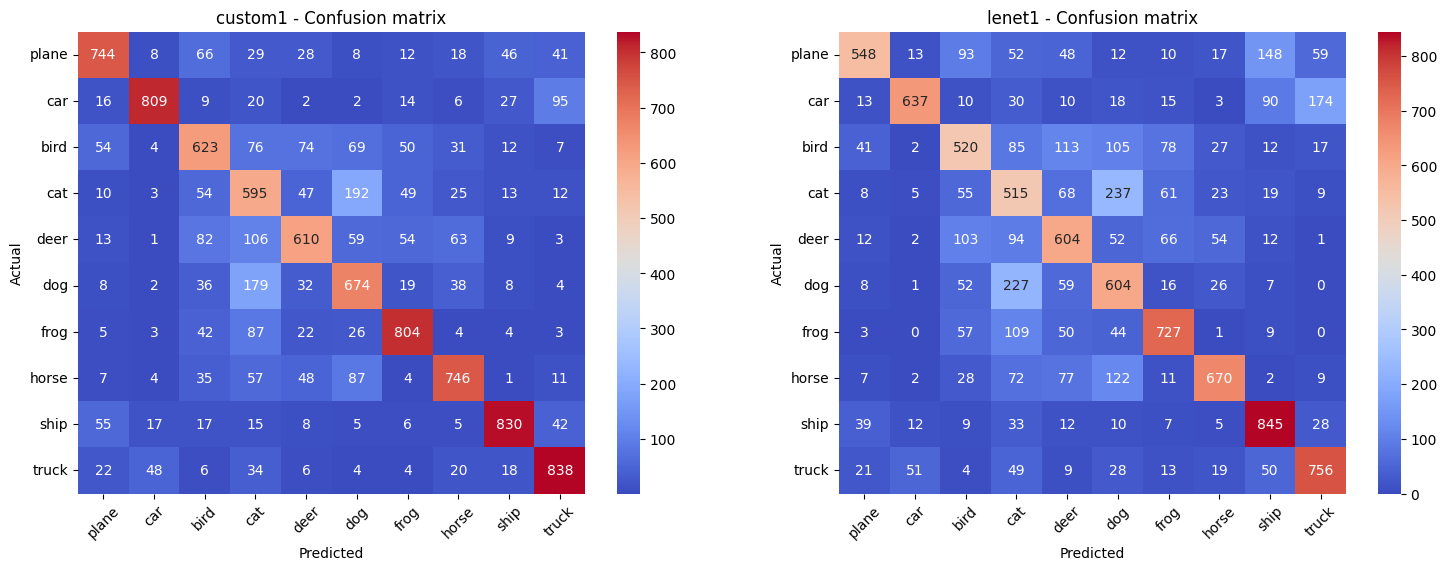

2022-08-12 15:25:44,436: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-12 15:25:45,260: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:25:45,262: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1
2022-08-12 15:25:45,595: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


1/1 [==============================] - 0s 9ms/step


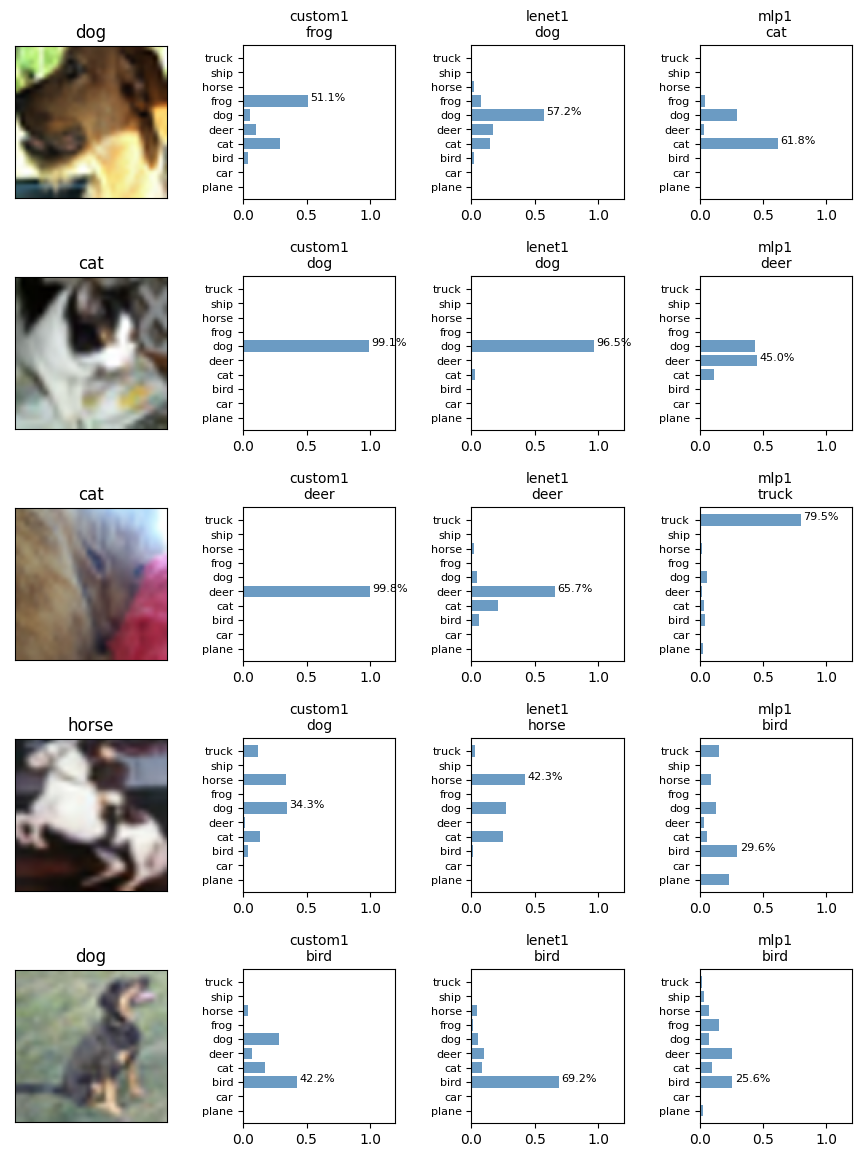

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1    custom1  cifar10_0808_cnt_5000.ipynb         466954       325.5   
2     lenet1  cifar10_0808_cnt_5000.ipynb         943330       154.9   
3       mlp1  cifar10_0808_cnt_5000.ipynb        3540362        75.5   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-12 15:25      0.2245     1.0402          0.9231         0.7273   
2  2022-08-12 15:19      0.5487     1.1222          0.8090         0.6426   
3  2022-08-12 15:16      1.5546     1.8729          0.4962         0.4367   

   train_auc  test_auc  
1     0.9966    0.9570  
2     0.9830    0.9370  
3     0.8810    0.8425

In [30]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-12 15:25:50,428: INFO: model_params.vgg8.dropout=0.3
2022-08-12 15:25:50,594: INFO: learning_rate=0.001
2022-08-12 15:25:50,594: INFO: model_params.vgg8.clip_value=None
2022-08-12 15:25:50,600: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 96, 96, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 96, 96, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 96, 96, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 96, 96, 64)        36928     
                                                              

2022-08-12 15:25:50,651: INFO: model_params.vgg8.epochs=15
2022-08-12 15:25:50,651: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/vgg8, monitor=val_accuracy)
2022-08-12 15:25:50,652: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-12 15:25:50,653: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-12 15:25:50,653: INFO: use LearningRateScheduler()
2022-08-12 15:25:50,654: INFO: steps_per_epoch=1562
2022-08-12 15:25:50,655: INFO: start training
2022-08-12 15:25:50,655: INFO: use_class_weight=False


Epoch 1/15
1562/1562 [==============================] - ETA: 0s - loss: 2.4082 - accuracy: 0.0985

2022-08-12 15:27:30,439: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/vgg8/assets


2022-08-12 15:27:31,584: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/vgg8/assets


1562/1562 [==============================] - 101s 64ms/step - loss: 2.4082 - accuracy: 0.0985 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/15
1562/1562 [==============================] - 96s 61ms/step - loss: 2.3028 - accuracy: 0.0996 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/15
1562/1562 [==============================] - 96s 62ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/15
1562/1562 [==============================] - 96s 62ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/15
1562/1562 [==============================] - 96s 62ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/15
1562/1562 [==============================] - 96s 61ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 7/15
1562/1562 [==============================] - 

2022-08-12 15:49:56,325: INFO: finish training [elapsed time: 1445.67 seconds]


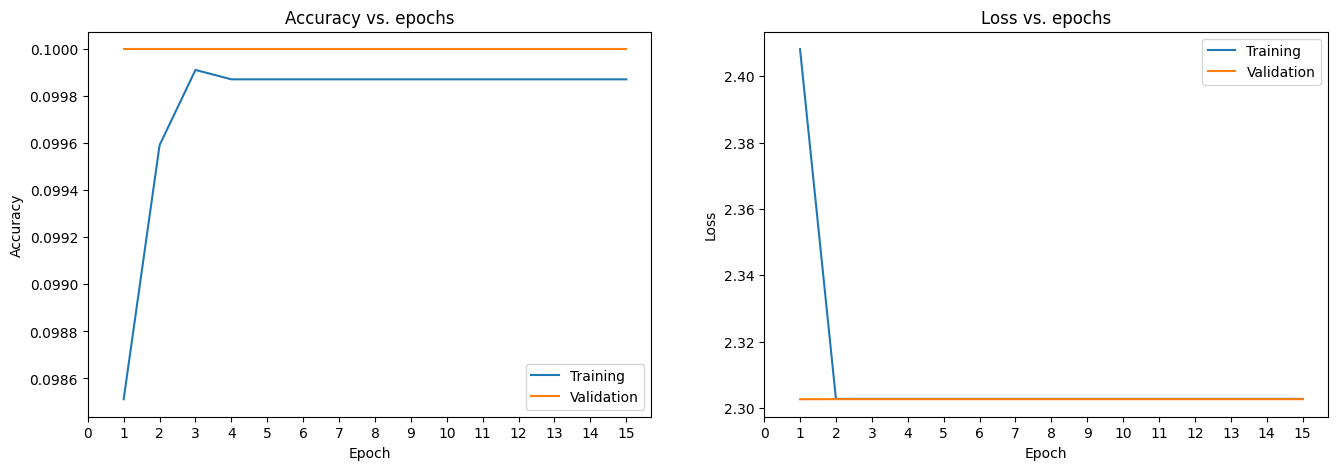

2022-08-12 15:49:56,711: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 5s 16ms/step


2022-08-12 15:51:06,702: INFO: test loss:2.3027
2022-08-12 15:51:06,703: INFO: test accuracy:0.1000
2022-08-12 15:51:06,705: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json


----------------------------------------save model results and generator----------------------------------------


2022-08-12 15:51:06,707: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-12 15:51:06,707: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:51:06,708: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:51:06,709: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1


----------------------------------------confusion matrix----------------------------------------


2022-08-12 15:51:07,658: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


313/313 [==============================] - 1s 3ms/step


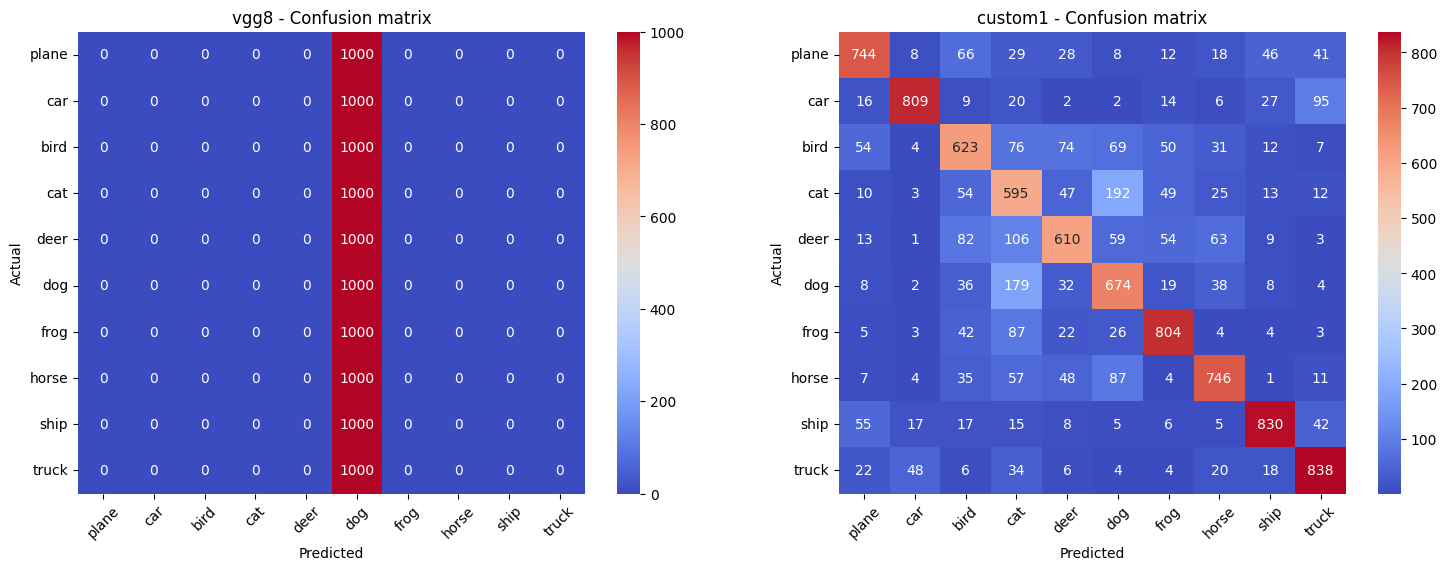

2022-08-12 15:51:16,444: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-12 15:51:17,351: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:51:17,353: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1
2022-08-12 15:51:18,150: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-12 15:51:18,152: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1
2022-08-12 15:51:18,480: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


1/1 [==============================] - 0s 8ms/step


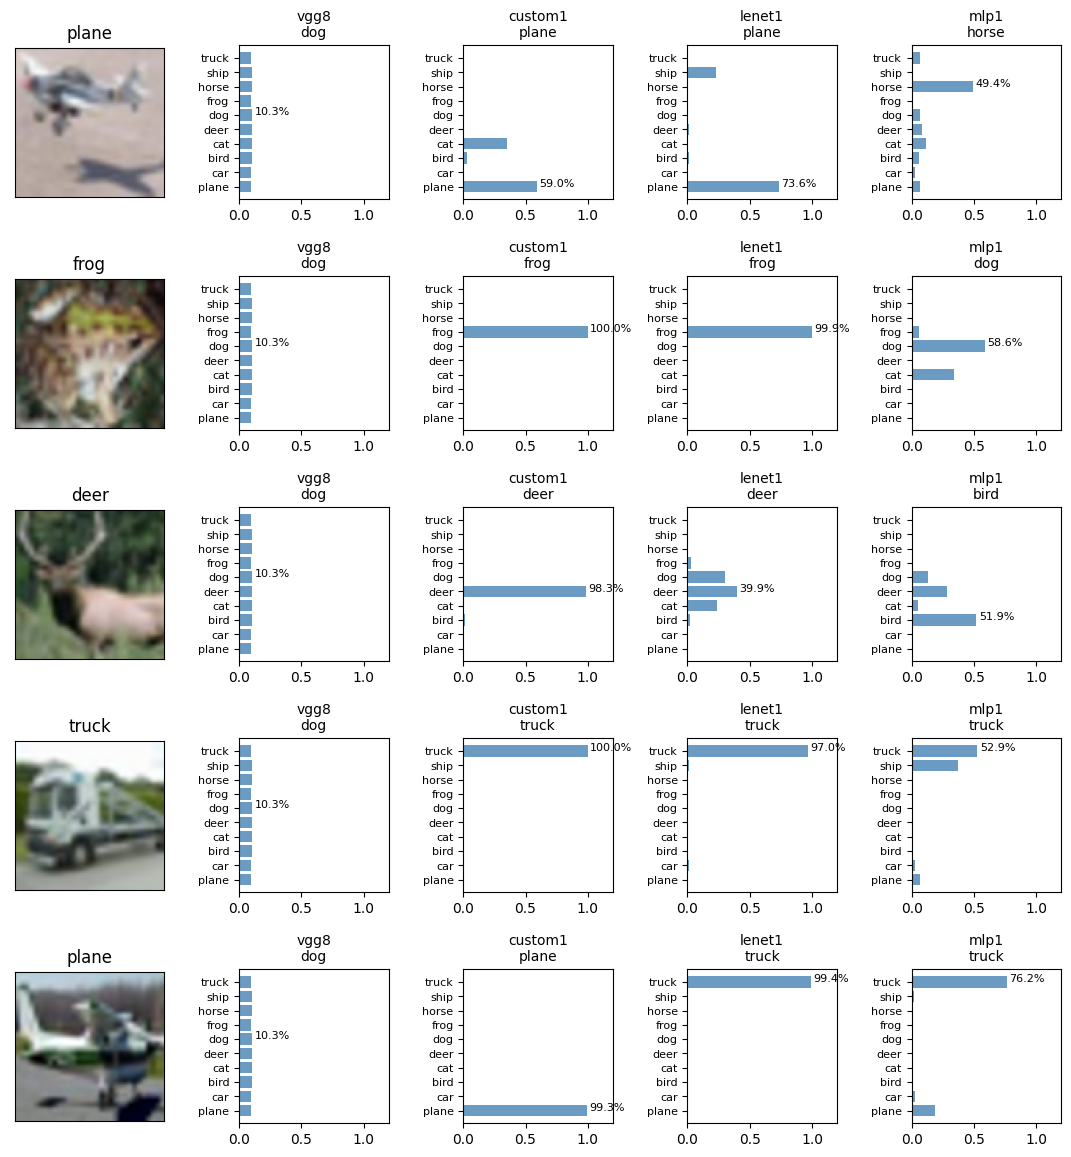

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1    custom1  cifar10_0808_cnt_5000.ipynb         466954       325.5   
2     lenet1  cifar10_0808_cnt_5000.ipynb         943330       154.9   
3       mlp1  cifar10_0808_cnt_5000.ipynb        3540362        75.5   
4       vgg8  cifar10_0808_cnt_5000.ipynb        5867210      1445.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-12 15:25      0.2245     1.0402          0.9231         0.7273   
2  2022-08-12 15:19      0.5487     1.1222          0.8090         0.6426   
3  2022-08-12 15:16      1.5546     1.8729          0.4962         0.4367   
4  2022-08-12 15:51      2.3027     2.3027          0.1000         0.1000   

   train_auc  test_auc  
1     0.9966    0.9570  
2     0.9830    0.9370  
3     0.8810    0.8425  
4     0.5000    0.5000

In [31]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-15 09:50:50,639: INFO: learning_rate=0.001
2022-08-15 09:50:50,640: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-15 09:50:50,648: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 96, 96, 3)    0           ['input_9[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 96, 96, 16)   448         ['rescaling_1[6][0]']            
                                                                                                  
 batch_normalization_28 (BatchN  (None, 96, 96, 16)  64          ['conv2d_30[0][0]']              
 ormalization)                                                                         

                                                                                                  
 conv2d_40 (Conv2D)             (None, 48, 48, 32)   9248        ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 48, 48, 32)  128         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 48, 48, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 48, 48, 32)   9248        ['activation_28[0][0]']          
                                                                                                  
 batch_nor

 add_29 (Add)                   (None, 24, 24, 64)   0           ['activation_35[0][0]',          
                                                                  'batch_normalization_46[0][0]'] 
                                                                                                  
 activation_37 (Activation)     (None, 24, 24, 64)   0           ['add_29[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 3, 3, 64)    0           ['activation_37[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 flatten_6 (Flatten)            (None, 576)          0           ['average_pooling2d_1[0][0]']    
                                                                                                  
 dense_13 

2022-08-15 09:50:50,778: INFO: model_params.resnet_v1_20.epochs=15
2022-08-15 09:50:50,778: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20, monitor=val_accuracy)
2022-08-15 09:50:50,779: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-15 09:50:50,780: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-15 09:50:50,780: INFO: use LearningRateScheduler()
2022-08-15 09:50:50,781: INFO: steps_per_epoch=1562
2022-08-15 09:50:50,782: INFO: start training
2022-08-15 09:50:50,782: INFO: use_class_weight=False


Epoch 1/15
1562/1562 [==============================] - ETA: 0s - loss: 1.4100 - accuracy: 0.5576

2022-08-15 09:52:29,787: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


2022-08-15 09:52:33,323: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 103s 64ms/step - loss: 1.4100 - accuracy: 0.5576 - val_loss: 1.3065 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 2/15
1562/1562 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.7025

2022-08-15 09:54:05,978: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


2022-08-15 09:54:08,811: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 95s 61ms/step - loss: 1.0069 - accuracy: 0.7025 - val_loss: 1.0939 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 3/15
1562/1562 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.7490

2022-08-15 09:55:41,131: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


2022-08-15 09:55:44,583: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 96s 61ms/step - loss: 0.8761 - accuracy: 0.7490 - val_loss: 1.0060 - val_accuracy: 0.7086 - lr: 0.0010
Epoch 4/15
1562/1562 [==============================] - ETA: 0s - loss: 0.7905 - accuracy: 0.7815

2022-08-15 09:57:16,790: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


2022-08-15 09:57:20,234: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 96s 61ms/step - loss: 0.7905 - accuracy: 0.7815 - val_loss: 0.9377 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 5/15
1562/1562 [==============================] - 86s 55ms/step - loss: 0.7246 - accuracy: 0.8050 - val_loss: 1.0538 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 6/15
1562/1562 [==============================] - 86s 55ms/step - loss: 0.6729 - accuracy: 0.8262 - val_loss: 0.9695 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 7/15
1562/1562 [==============================] - 86s 55ms/step - loss: 0.6292 - accuracy: 0.8426 - val_loss: 1.0444 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 8/15
1562/1562 [==============================] - 86s 55ms/step - loss: 0.5930 - accuracy: 0.8582 - val_loss: 1.1224 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 9/15
1562/1562 [==============================] - 86s 55ms/step - loss: 0.5623 - accuracy: 0.8718 - val_loss: 1.4011 - val_accuracy: 0.6885 - lr: 0.0010
Epoch 10/15
1562/1562 [==============================] - 

2022-08-15 10:10:21,451: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


2022-08-15 10:10:24,291: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20/assets


1562/1562 [==============================] - 95s 61ms/step - loss: 0.4914 - accuracy: 0.9064 - val_loss: 1.2573 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 14/15
1562/1562 [==============================] - 86s 55ms/step - loss: 0.4829 - accuracy: 0.9121 - val_loss: 1.3724 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 15/15
1562/1562 [==============================] - 86s 55ms/step - loss: 0.4759 - accuracy: 0.9156 - val_loss: 1.6016 - val_accuracy: 0.7113 - lr: 0.0010


2022-08-15 10:13:16,545: INFO: finish training [elapsed time: 1345.76 seconds]


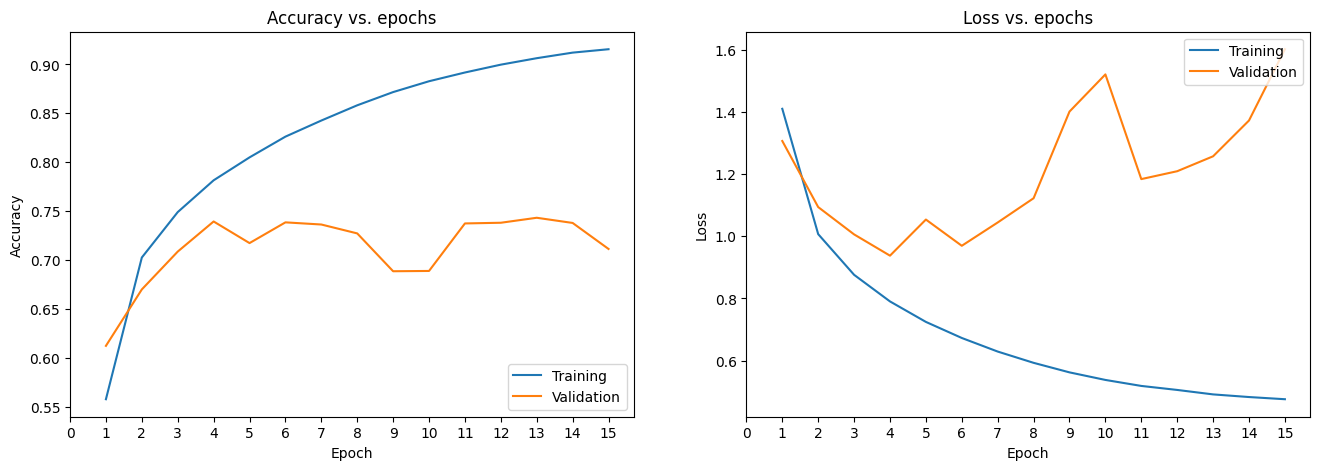

2022-08-15 10:13:16,944: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 4s 12ms/step


2022-08-15 10:14:18,536: INFO: test loss:1.2573
2022-08-15 10:14:18,536: INFO: test accuracy:0.7432
2022-08-15 10:14:18,540: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-15 10:14:18,542: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-15 10:14:18,542: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-15 10:14:18,544: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-15 10:14:18,544: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-15 10:14:19,463: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


313/313 [==============================] - 1s 3ms/step


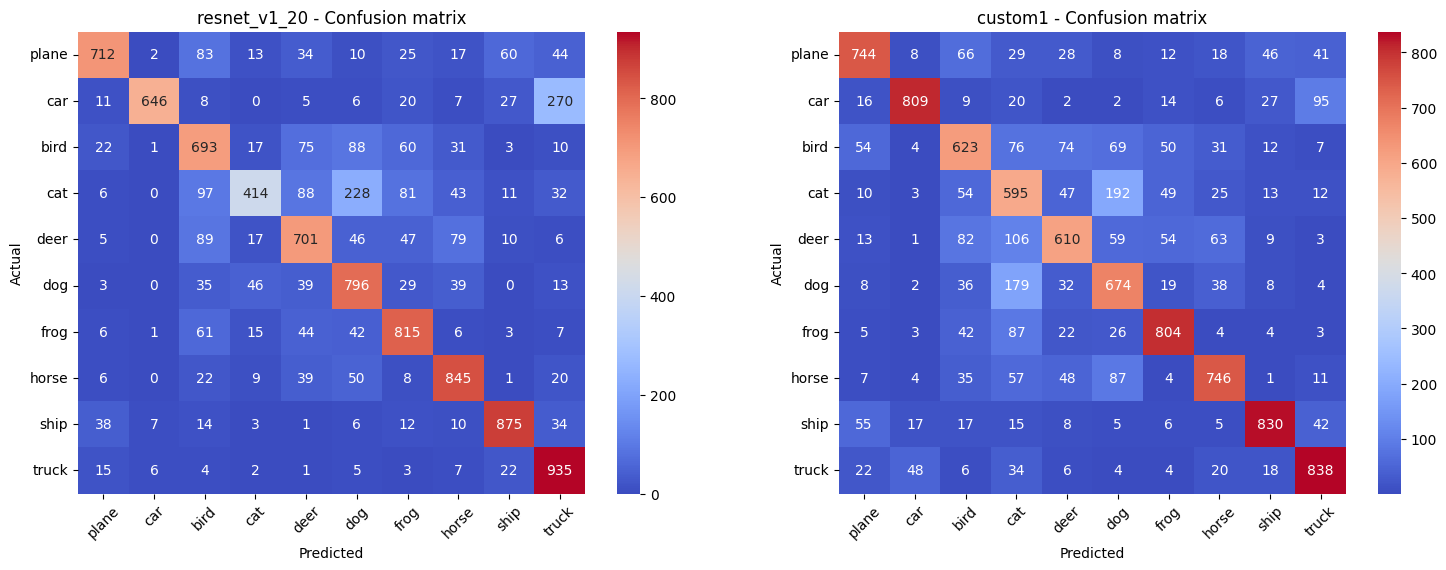

2022-08-15 10:14:27,222: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-15 10:14:28,936: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-15 10:14:28,939: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/lenet1
2022-08-15 10:14:29,762: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-15 10:14:29,764: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/mlp1
2022-08-15 10:14:30,110: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator
2022-08-15 10:14:30,111: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_note

1/1 [==============================] - 0s 44ms/step


2022-08-15 10:14:36,833: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f18ba112f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 11ms/step


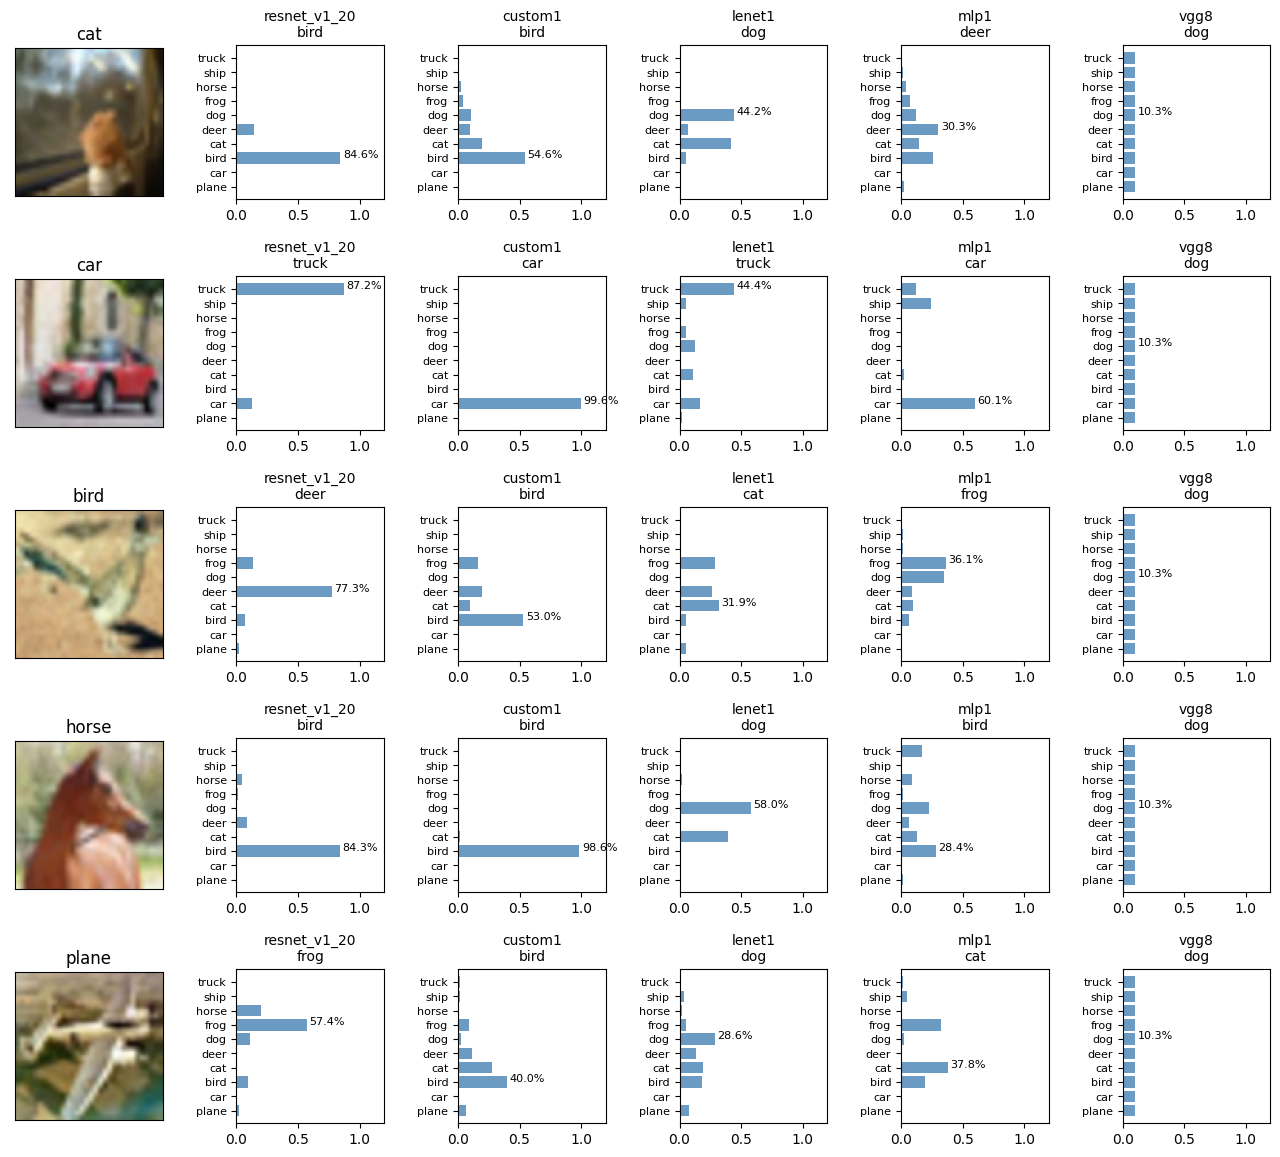

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1  resnet_v1_20  cifar10_0808_cnt_5000.ipynb         278186      1345.8   
2       custom1  cifar10_0808_cnt_5000.ipynb         466954       325.5   
3        lenet1  cifar10_0808_cnt_5000.ipynb         943330       154.9   
4          mlp1  cifar10_0808_cnt_5000.ipynb        3540362        75.5   
5          vgg8  cifar10_0808_cnt_5000.ipynb        5867210      1445.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-15 10:14      0.8131     1.2573          0.8227         0.7432   
2  2022-08-12 15:25      0.2245     1.0402          0.9231         0.7273   
3  2022-08-12 15:19      0.5487     1.1222          0.8090         0.6426   
4  2022-08-12 15:16      1.5546     1.8729          0.4962         0.4367   
5  2022-08-12 15:51      2.3027     2.3027          0.1000         0.1000   

   train_auc  test_auc  
1     0.9880    0.9695  
2     0.9966    0.9570  
3     0.9830    0.9370  
4     0.8810    0.8425  
5     0.5000    0.5000

In [37]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Pretrained Model + Fune-Tune

#### MobileNet V2

In [42]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape + (3,),
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.Xception(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                            input_shape=input_shape + (3,),
                                            include_top=False)
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_12[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 12, 12, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 12, 12, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_57 (Conv2D)             (None, 6, 6, 728)    186368      ['add_43[0][0]']                 
                                                                                                  
 block4_pool (MaxPooling2D)     (None, 6, 6, 728)    0           ['block4_sepconv2_bn[0][0]']     
          

 block7_sepconv1_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 6, 6, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 6, 6, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv2_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv2[0][0]']        
 lization)

                                                                                                  
 block10_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_49[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 6, 6, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
                                                                                                  
 block10_s

 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_52 (Add)                   (None, 6, 6, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_51[0][0]']                 
                                                                                                  
 block13_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_52[0][0]']                 
 on)                                                                                              
          

In [65]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=None):
    learning_rate = learning_rate if learning_rate is not None else params.learning_rate/5
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model 

2022-08-15 10:19:28,379: INFO: learning_rate=0.001
2022-08-15 10:19:28,380: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-15 10:19:28,389: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2


Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 10)                20490     
                                            

2022-08-15 10:19:28,413: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-15 10:19:28,414: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-15 10:19:28,414: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-15 10:19:28,415: INFO: use LearningRateScheduler()
2022-08-15 10:19:28,416: INFO: steps_per_epoch=1562
2022-08-15 10:19:28,416: INFO: start training
2022-08-15 10:19:28,417: INFO: use_class_weight=False


Epoch 1/20
1562/1562 [==============================] - ETA: 0s - loss: 2.3031 - accuracy: 0.0999

2022-08-15 10:22:35,510: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 40). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2/assets


2022-08-15 10:22:41,927: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 194s 121ms/step - loss: 2.3031 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/20
1562/1562 [==============================] - 170s 109ms/step - loss: 2.3028 - accuracy: 0.0996 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/20
1562/1562 [==============================] - 171s 109ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/20
1562/1562 [==============================] - 170s 109ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/20
1562/1562 [==============================] - 171s 109ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/20
1562/1562 [==============================] - 171s 109ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 7/20
1562/1562 [=======================

2022-08-15 11:16:45,876: INFO: finish training [elapsed time: 3437.46 seconds]


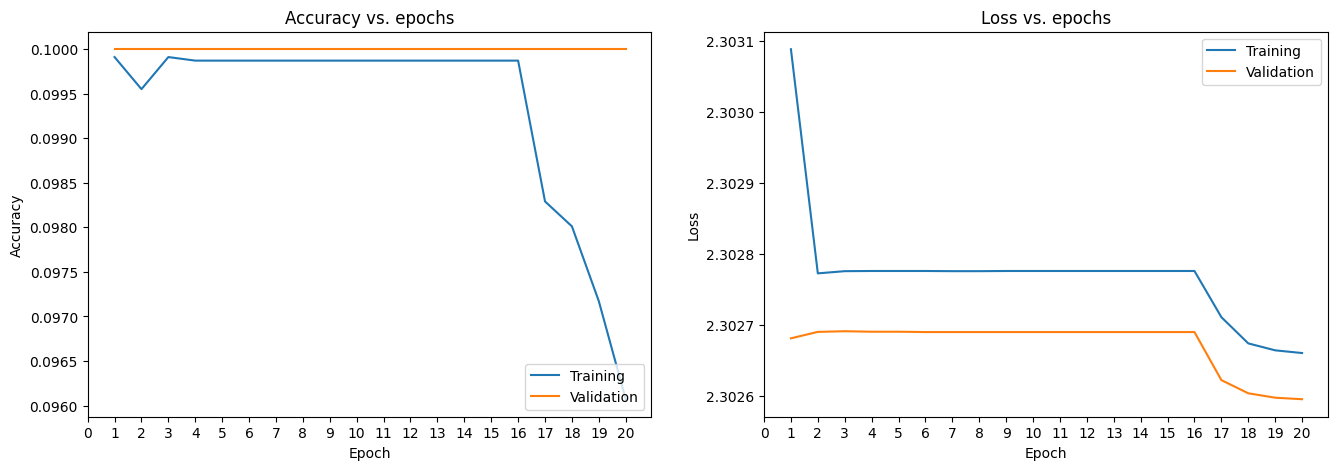

In [44]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=rescale)
model.summary()
history = helper.train(model, epochs=20)

In [49]:
type(params.fine_tune_callbacks) 

qbz95.utils.dict_to_object.DictToObject

2022-08-15 12:58:41,668: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-15 12:58:41,669: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-15 12:58:41,670: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-15 12:58:41,671: INFO: steps_per_epoch=1562
2022-08-15 12:58:41,672: INFO: start training
2022-08-15 12:58:41,672: INFO: use_class_weight=False


Epoch 1/30
1561/1562 [============================>.] - ETA: 0s - loss: 2.3027 - accuracy: 0.0995

2022-08-15 13:00:14,277: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 40). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2/assets


2022-08-15 13:00:18,546: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 98s 58ms/step - loss: 2.3027 - accuracy: 0.0995 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/30
1562/1562 [==============================] - 70s 45ms/step - loss: 2.3028 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/30
1562/1562 [==============================] - 70s 45ms/step - loss: 2.3028 - accuracy: 0.0987 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/30
1562/1562 [==============================] - 71s 45ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/30
1562/1562 [==============================] - 71s 45ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/30
1562/1562 [==============================] - 71s 45ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 7/30
1562/1562 [==============================] - 7

2022-08-15 13:34:31,864: INFO: finish training [elapsed time: 2150.19 seconds]


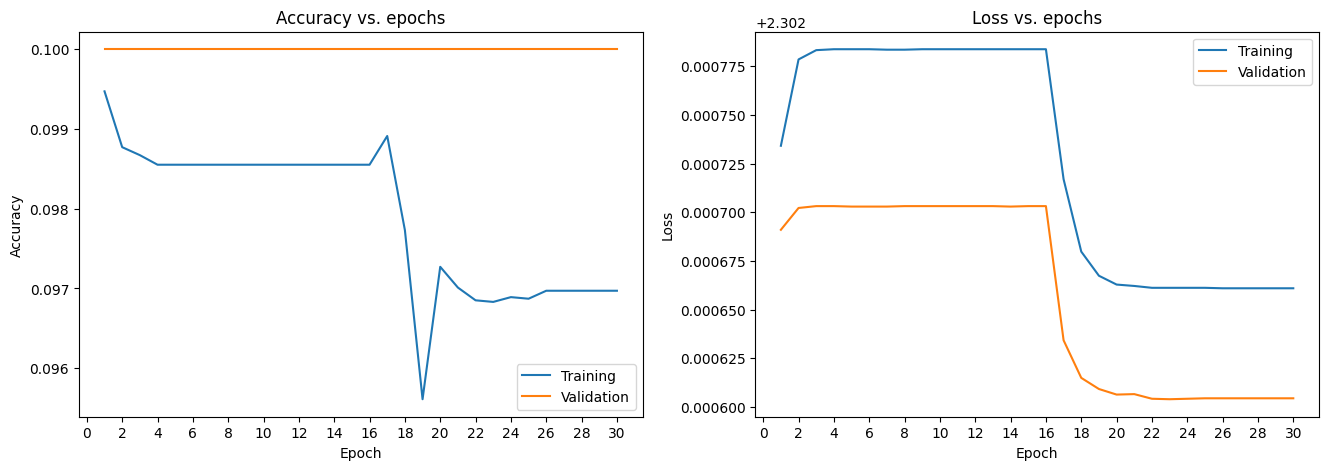

In [66]:
model = fine_tuning(helper, model, base_model, learning_rate=0.001) 
callbacks = helper.get_callbacks(model,  callbacks=params.fine_tune_callbacks, verbose=True)
history = helper.train(model, epochs=30, callbacks=callbacks) 

2022-08-16 02:47:05,227: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 7s 22ms/step


2022-08-16 02:48:46,750: INFO: test loss:2.3027
2022-08-16 02:48:46,751: INFO: test accuracy:0.1000
2022-08-16 02:48:46,754: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-16 02:48:46,755: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/results.json
2022-08-16 02:48:46,756: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


----------------------------------------save model results and generator----------------------------------------


2022-08-16 02:48:46,757: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_cnt_5000/default.generator


----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 7s 22ms/step


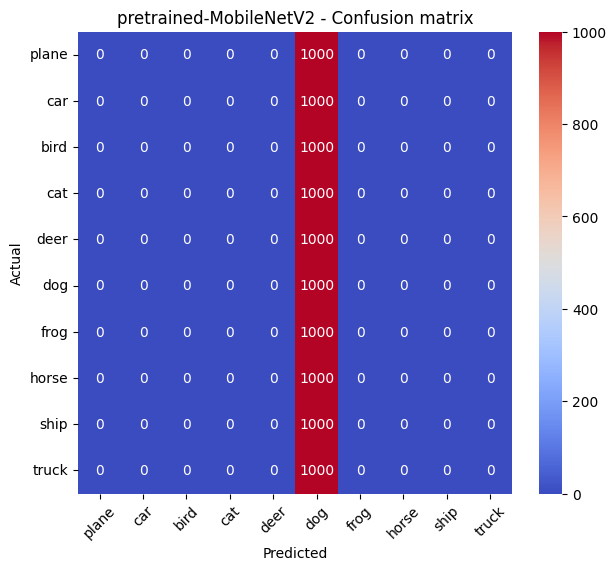

----------------------------------------sample analysis----------------------------------------
1/1 [==============================] - 0s 17ms/step


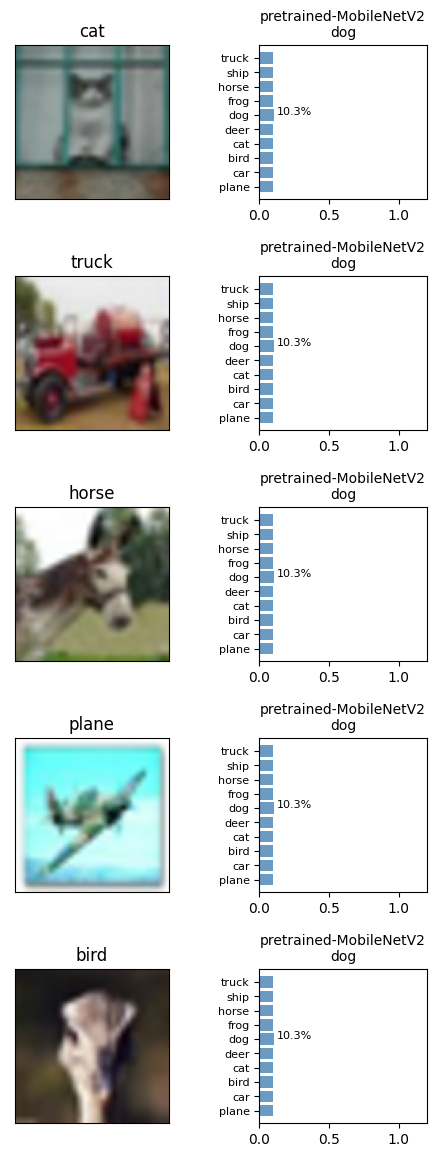

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0808_cnt_5000.ipynb        9498834   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1      2150.2  2022-08-16 02:48      2.3027     2.3027             0.1   

   test_accuracy  train_auc  test_auc  
1            0.1        0.5       0.5

In [67]:
helper.model_summary(model, history, show_sample_analysis=True) 

## Evaluation

### Best Model

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)